<a href="https://colab.research.google.com/github/ManDes71/Rakuten_Text_Classification_TensorFlow/blob/main/notebooks/Modele_RNN_Spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quelles sont les fonctionnalités de spaCy ?**

**La bibliothèque Python spaCy peut intervenir dans la réalisation de plusieurs tâches liées aux projets NLP. Pour ce faire, la bibliothèque utilise différentes fonctionnalités comme la tokenization, la lemmatisation, l'analyse des dépendances, la reconnaissance de phrase ou d'entité, le tagging POS, etc.**

In [1]:
# Vérification que les modèles spaCy sont installés
# (Les modèles sont installés dans le Dockerfile)

import spacy

models_to_check = [
    "en_core_web_sm",
    "fr_core_news_sm", 
    "es_core_news_sm",
    "de_core_news_sm",
    "nl_core_news_sm",
    "it_core_news_sm"
]

print("Vérification des modèles spaCy installés :")
for model in models_to_check:
    try:
        spacy.load(model)
        print(f"✓ {model}")
    except OSError:
        print(f"✗ {model} - Non installé")

print("\n✓ Vérification terminée !")

Vérification des modèles spaCy installés :
✓ en_core_web_sm
✓ fr_core_news_sm
✓ es_core_news_sm
✓ de_core_news_sm
✓ nl_core_news_sm
✓ it_core_news_sm

✓ Vérification terminée !


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from keras.optimizers import SGD,Adam
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout

from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer,accuracy_score,classification_report
import nltk
import re
from sklearn import svm
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import swifter

# set the max columns to none
pd.set_option('display.max_columns', None)

2026-02-15 19:08:20.332379: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-15 19:08:21.936316: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-15 19:08:21.946716: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-15 19:08:21.946791: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUM

1 Physical GPUs, 1 Logical GPUs


/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MAXLEN = 600
NUM_WORDS = 70000
EMBEDDING_DIM = 200

In [4]:
import configparser
import sys
sys.path.append('../src')
import Bibli_DataScience_3_3 as ds
config = configparser.ConfigParser()
config.read('Rakuten_config.ini')

section :  ['DOSSIER', 'FICHIER']


[]

In [5]:

import pandas as pd

# lecture des données sources d'entrainement
df_feats=pd.read_csv(ds.get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(ds.get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

# récupération du fichier df_langue.csv
df_langue=pd.read_csv(ds.get_RACINE_DOSSIER() + 'df_langue.csv')
df=df.merge(df_langue.drop(['Unnamed: 0','prdtypecode'], axis=1),on='Id',how='inner')

Lcat=df_target.sort_values(by='prdtypecode')['prdtypecode'].unique()


nomenclature=pd.read_csv(ds.get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']

#
stopwordFR = pd.read_csv(ds.get_RACINE_DOSSIER() + 'stopwords_FR_02.csv')
stop_words = stopwordFR['MOT'].tolist()
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
df_feats

,Unnamed: 0,designation,description,productid,imageid
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786
...,...,...,...,...,...
84911,84911,The Sims [ Import Anglais ],NaN,206719094,941495734
84912,84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883
84913,84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617
84914,84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403


In [7]:
df_target

,Unnamed: 0,prdtypecode
0,0,10
1,1,2280
2,2,50
3,3,1280
4,4,2705
...,...,...
84911,84911,40
84912,84912,2583
84913,84913,2280
84914,84914,1560


In [8]:
import pandas as pd

def combine_description_and_designation(row):
    partie_design = row['designation'] if isinstance(row['designation'], str) else ''
    partie_descrip = row['description'] if isinstance(row['description'], str) else ''
    return partie_design + ' ' + partie_descrip if len(partie_descrip) > 0 else partie_design

# Appliquer la fonction à chaque ligne
df_feats['phrases'] = df_feats.swifter.apply(combine_description_and_designation, axis=1)


Pandas Apply: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84916/84916 [00:00<00:00, 111365.31it/s]


# ETAPE 1 :
## Passage en minuscule
Dans un premier temps, nous transformons les majuscules en minuscules car les étapes suivantes sont sensibles à la casse
## ETAPE 2: Tokenisation
 Il s’agit de décomposer une phrase, et donc un document, en tokens. Un token est un élément correspondant à un mot ou une ponctuation, cependant de nombreux cas ne sont pas triviaux à traiter :
Les mots avec un trait d’union, exemple : peut être et peut-être qui ont des significations très différentes ;
Les dates et heures qui peuvent être séparées par des points, des slashs, des deux points ;
Les apostrophes ;
Les caractères spéciaux : émoticônes, formules mathématiques.


In [9]:

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = str(w)
    # Remplacer les entités HTML par des caractères spécifiques ou les supprimer
    replacements = {
        '&eacute;': 'e',
        '&amp;': '',    # Esperluette
        '&lt;': '',     # Inférieur à
        '&gt;': '',     # Supérieur à
        '&quot;': '',   # Guillemet double
        '&apos;': '',   # Apostrophe
        '&nbsp;': '',   # Espace insécable
        '&copy;': '',   # Droit d'auteur
        '&reg;': '',    # Marque déposée
        '&euro;': '',   # Symbole de l'euro
        '&rsquo;': '',
        '&agrave;': 'a',
        '&ccedil;': 'c',
        '&egrave;': 'e',
        '&iacute;': 'i',
        '&ntilde;': 'n',
        '&ouml;': 'o',
    }
    for entity, replacement in replacements.items():
        w = w.replace(entity, replacement)
    w = unicode_to_ascii(w.lower().strip())
    # Appliquer les autres règles de nettoyage
    w = w.replace("n°", "??numero??")
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!°]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)
    w = w.replace("? ? numero ? ?", "n°")


    # Suppression des stopwords
    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()

df_feats['WordRNN'] = df_feats['phrases'].swifter.apply(lambda x :preprocess_sentence(x))
df_feats.head()

Pandas Apply: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84916/84916 [01:03<00:00, 1339.20it/s]


,Unnamed: 0,designation,description,productid,imageid,phrases,WordRNN
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,Olivia: Personalisiertes Notizbuch / 150 Seite...,olivia personalisiertes notizbuch seiten punkt...
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,journal arts n° art marche salon art asiatique...
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,grand stylet ergonomique bleu gamepad nintendo...
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,Peluche Donald - Europe - Disneyland 2000 (Mar...,peluche donald europe disneyland marionnette d...
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,La Guerre Des Tuques Luc a des id&eacute;es de...,guerre tuques luc idees grandeur . veut organi...


## ETAPE 3: Retrait des stopwords
Ensuite, nous retirons les mots appartenant aux stopwords. Il s’agit de listes de mots définies au préalable soit par l’utilisateur soit dans des librairies existantes. Ces listes se composent de mots qui n’apportent aucune information, qui sont en général très courants et donc présents dans la plupart des documents, par exemple : je, nous, avoir (le verbe et ses conjugaisons). La suppression de ces stopwords permet de ne pas polluer les représentations des documents afin qu’elle ne contienne que les mots représentatifs et significatifs. Ce “nettoyage” du texte peut aussi s’accompagner de la suppression d’autres éléments comme les nombres, les dates, la ponctuation etc.

In [10]:
import string

import spacy

# Chargement des modèles de langue avec un mappage spécifique
modeles = {
    'en': spacy.load("en_core_web_sm"),
    'es': spacy.load("es_core_news_sm"),
    'de': spacy.load("de_core_news_sm"),
    'nl': spacy.load("nl_core_news_sm"),
    'it': spacy.load("it_core_news_sm"),
    'ca': spacy.load("fr_core_news_sm"),  # Utilise le modèle français pour le catalan
    'fr': spacy.load("fr_core_news_sm")
}
# Ajustement de la fonction preprocess_text
def preprocess_text(text):
    try:
        lang = detect(text)
    except:
        lang = "fr"  # Définit le français comme langue par défaut
    #text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
   # Chargement du modèle de langue approprié basé sur le langage détecté ou fourni
    nlp = modeles.get(lang, modeles['fr'])  # Utilise le français comme langue par défaut si non trouvé

    # Traitement du texte avec spaCy
    doc = nlp(text)

    # Filtrage des tokens qui ne sont pas des stopwords et qui ne sont pas des signes de ponctuation
    tokens_sans_stopwords = [token.text for token in doc if not token.is_stop and token.text not in string.punctuation]

    return ' '.join(tokens_sans_stopwords).strip()

# Supposons df_feats est votre DataFrame et 'concatenated' la colonne à traiter
# Appliquer preprocess_text à chaque valeur de la colonne 'concatenated'
df_feats['tokenized'] = df_feats['WordRNN'].swifter.apply(preprocess_text)


Pandas Apply: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84916/84916 [13:09<00:00, 107.61it/s]


## ETAPE 4 : Groupement sémantique
Dès lors, nous disposons pour chaque document d’une liste “nettoyée” de mots porteurs de sens et séparés en tokens. Mais un mot peut être écrit au pluriel, au singulier ou avec différents accords et les verbes peuvent être conjugués à différents temps et personnes.
Nous devons donc réduire les différences grammaticales des mots en trouvant des formes communes. Pour ce faire, nous disposons de deux méthodes distinctes :
La stemmatisation, qui ne prend pas en compte le contexte de la phrase
La lemmatisation, qui prend en compte le contexte
### ETAPE 4.2 : La Lemmatisation
La lemmatisation, qui prend en considération le contexte dans lequel le mot est écrit, a pour but de trouver la forme canonique du mot, le lemme. Par conséquent, elle doit se faire après la transformation des lettres majuscules en minuscules et avant la tokenisation car les mots présents avant et après sont importants pour déterminer la nature du mot.
Le lemme correspond à l’infinitif des verbes et à la forme au masculin singulier des noms, adjectifs et articles. Par exemple cette méthode est capable de faire la différence entre “nous avions” : verbe avoir et “les avions” : le pluriel d’un avion. La lemmatisation de la phrase d’exemple est présentée dans la figure suivante.

In [11]:
X_text_train, X_text_test, y_train, y_test = train_test_split(df_feats.tokenized, df_target.prdtypecode, test_size=0.2, random_state=1234)

In [12]:
import spacy
print(spacy.__version__)

3.7.2


In [13]:
import spacy
from langdetect import detect
import string

# Chargement des modèles SpaCy
nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_sm')
nlp_es = spacy.load('es_core_news_sm')
nlp_de = spacy.load('de_core_news_sm')
nlp_nl = spacy.load('nl_core_news_sm')
nlp_it = spacy.load('it_core_news_sm')

# Fonction pour sélectionner le modèle SpaCy en fonction de la langue détectée
def get_spacy_model(lang):
    if lang == 'fr':
        return nlp_fr
    elif lang == 'es':
        return nlp_es
    elif lang == 'en':
        return nlp_en
    elif lang == 'de':
        return nlp_de
    elif lang == 'nl':
        return nlp_nl
    elif lang == 'it':
        return nlp_it
    else:  # par défaut à l'anglais
        return nlp_fr



# Fonction pour nettoyer, tokeniser et appliquer la lemmatisation
def preprocess_spacy(text):
    # Détection de la langue
    try:
        lang = detect(text)
    except:
        lang = "en"  # Langue par défaut

    # Sélection du modèle SpaCy approprié
    nlp = get_spacy_model(lang)

    # Nettoyage du texte
    #text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Lemmatisation avec SpaCy
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space]

    return lemmatized_tokens





### ETAPE 5 : Word Embedding
 Le word embedding (plongement de mots) désigne un ensemble de méthode d’apprentissage visant à représenter les mots d’un texte par des vecteurs de nombres réels.
 le word embedding est capable en réduisant la dimension de capturer le contexte, la similarité sémantique et syntaxique (genre, synonymes, …) d’un mot. Par exemple, on pourrait s’attendre à ce que les mots « chien » et « chat » soient représentés par des vecteurs relativement peu distants dans l’espace vectoriel où sont définis ces vecteurs.

Comme pour les images, nous souhaitons que ça soit le modèle qui choisisse les caractéristiques les plus pertinentes représentant le mot. Par exemple, la caractéristique « être vivant » pourrait être intéressante pour différencier « chien » et « ordinateur », et rapprocher « chien » et « chat ».

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Application de la fonction de prétraitement adaptée
X_text_train_preprocessed = [preprocess_spacy(tokens) for tokens in X_text_train]
X_text_test_preprocessed = [preprocess_spacy(tokens) for tokens in X_text_test]

# Puis, continuez avec la tokenisation (dans ce cas, la re-tokenisation) et le padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts([' '.join(tokens) for tokens in X_text_train_preprocessed])


X_train = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in X_text_train_preprocessed])
X_test = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in X_text_test_preprocessed])


X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAXLEN, padding='post', truncating='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAXLEN, padding='post', truncating='post')



print("Séquences tokenisées, lemmées et paddées :")

Séquences tokenisées, lemmées et paddées :


In [15]:
from tensorflow.keras.layers import  Dropout ,Conv1D,Flatten,Bidirectional,GRU,BatchNormalization

In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y_classes_converted = label_encoder.fit_transform(y_train)
#y_classes_train = label_encoder.transform(y_train)
# Maintenant, utilisez to_categorical
y_train_Network = to_categorical(y_classes_converted)
y_classes_converted = label_encoder.transform(y_test)
#y_classes_test = label_encoder.transform(y_test)
# Maintenant, utilisez to_categorical
y_test_Network = to_categorical(y_classes_converted)
print(y_train_Network.shape)
print(y_test_Network.shape)


(67932, 27)
(16984, 27)


In [18]:
vocab_size = len(tokenizer.word_index) + 1  # Taille du vocabulaire
embedding_dim = EMBEDDING_DIM  # Dimension de l'espace d'embedding
max_length = MAXLEN  # Déjà calculé lors du prétraitement
num_categories = 27  # Nombre de catégories

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, ))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
# Ajout d'une couche GRU
model.add(GRU(128, return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Augmentation du taux de dropout pour réduire le surajustement
model.add(Dense(num_categories, activation='softmax'))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras import callbacks
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=1,
                            mode='min')


In [20]:
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


training_history = model.fit(X_train, y_train_Network,
    batch_size = 32,
    epochs=5,
    validation_data = [X_test, y_test_Network],callbacks=[lr_plateau])

Epoch 1/5


2026-02-15 19:52:30.778981: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


2123/2123 ━━━━━━━━━━━━━━━━━━━━ 138s 61ms/step - accuracy: 0.5060 - loss: 1.7029 - val_accuracy: 0.7899 - val_loss: 0.7352 - learning_rate: 0.0010
Epoch 2/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 139s 65ms/step - accuracy: 0.8631 - loss: 0.4768 - val_accuracy: 0.7962 - val_loss: 0.7493 - learning_rate: 0.0010
Epoch 3/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 133s 62ms/step - accuracy: 0.9379 - loss: 0.2205 - val_accuracy: 0.8049 - val_loss: 0.8030 - learning_rate: 0.0010
Epoch 4/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 128s 60ms/step - accuracy: 0.9661 - loss: 0.1228 - val_accuracy: 0.7953 - val_loss: 0.9474 - learning_rate: 0.0010
Epoch 5/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9778 - loss: 0.0825
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 126s 59ms/step - accuracy: 0.9778 - loss: 0.0825 - val_accuracy: 0.8060 - val_loss: 1.0500 - learning_rate: 0.0010


In [21]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
test_pred_original=label_encoder.inverse_transform(y_pred)
test_pred_original

531/531 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step


array([2522, 1920, 2280, ..., 2583,   40,   50])

In [22]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
tloss = training_history.history['loss']
tvalloss=training_history.history['val_loss']

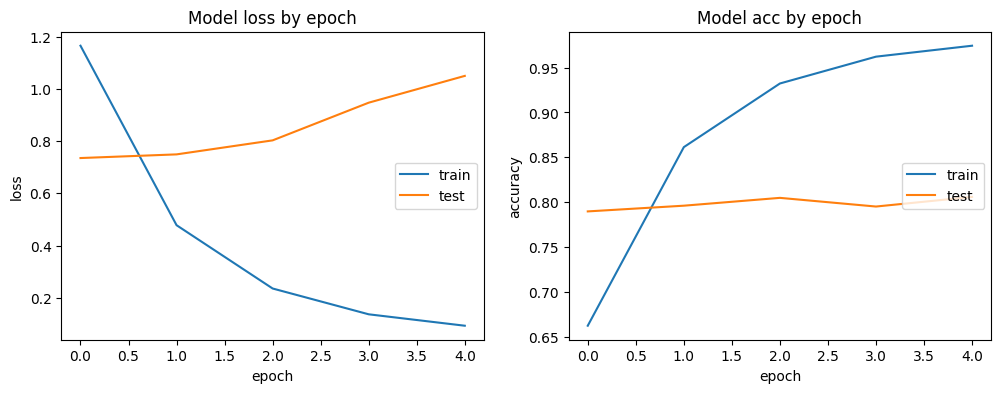

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tloss)
plt.plot(tvalloss)
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')



plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

### Rapport de classification

In [24]:

y_test_original=y_test
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test_original, test_pred_original)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test_original, test_pred_original)))

Précision de la prédiction: 80.59938765897316 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.45      0.52      0.48       643
          40       0.56      0.74      0.64       503
          50       0.81      0.82      0.81       319
          60       0.91      0.90      0.91       179
        1140       0.66      0.80      0.72       545
        1160       0.85      0.87      0.86       793
        1180       0.66      0.60      0.63       144
        1280       0.76      0.67      0.71      1002
        1281       0.66      0.46      0.54       408
        1300       0.95      0.93      0.94       993
        1301       0.97      0.91      0.94       162
        1302       0.86      0.78      0.82       514
        1320       0.78      0.80      0.79       664
        1560       0.84      0.82      0.83       993
        1920       0.86      0.94      0.90       832
        1940       0.86      0.7

In [25]:
import pandas as pd
df_test = pd.DataFrame({'tokenized': X_text_test, 'prdtypecode': y_test})
df_test['predict']=test_pred_original
df_test.head()

,tokenized,prdtypecode,predict
66047,stabilo lot stylos feutre film ohpen universal...,2522,2522
29942,housse fauteuil integrale elastique protectric...,1920,1920
58440,miroir sprint n° campionnissimo valet,2280,2280
55079,brisons glace cold hearted icecrown,1160,1160
11424,little prince resine prince accueil table figu...,2060,2060


### Tableau des 5 classes les plus prédites pour chaque classe réélle

In [26]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    print(df_test[df_test['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.520995
2403    0.102644
40      0.087092
2705    0.083981
2280    0.063764
Name: proportion, dtype: float64
40    ------    jeux video pour pc et consoles
predict
40      0.739563
10      0.063618
2462    0.035785
1160    0.031809
1140    0.019881
Name: proportion, dtype: float64
50    ------     accesoires jeux video
predict
50      0.818182
2462    0.047022
1140    0.031348
40      0.028213
1280    0.021944
Name: proportion, dtype: float64
60    ------    consoles de jeux video
predict
60      0.899441
2462    0.039106
50      0.022346
40      0.016760
2905    0.005587
Name: proportion, dtype: float64
1140    ------    produits derives “geeks” et figurines
predict
1140    0.798165
1280    0.031193
40      0.027523
10      0.025688
1160    0.020183
Name: proportion, dtype: float64
1160    ------    cartes collectionables
predict
1160    0.866330
10      0.045397
40      0.036570
1140    0.007566
2280    0.006305
Name: proportion, dtype: float64

In [27]:
top5_df = pd.DataFrame({'prdtypecode':y_test_original ,'predict': test_pred_original})

df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')
top5_df.head()

,prdtypecode,predict
66047,2522,2522
29942,1920,1920
58440,2280,2280
55079,1160,1160
11424,2060,2060


### Tableau des repartitions des **classes prédites** pour chaque **classe réelle**

In [28]:
df_pred = pd.DataFrame()
for c in Lcat:
            s = df_cross.loc[c].sort_values(ascending=False)[:5]
            df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
            df_pred = pd.concat([df_pred, df_temp], ignore_index=True)

In [29]:
df_pred

,Categorie,predict,pourc,predict2,pourc2,predict3,pourc3
0,10,10,0.393468,2403,0.143079,2705,0.118196
1,40,40,0.594433,1281,0.089463,10,0.055666
2,50,50,0.815047,2462,0.050157,1280,0.028213
3,60,60,0.821229,2462,0.072626,50,0.061453
4,1140,1140,0.631193,1280,0.165138,1320,0.036697
5,1160,1160,0.829760,10,0.031526,1281,0.023960
6,1180,1180,0.534722,1281,0.083333,1140,0.062500
7,1280,1280,0.753493,1281,0.050898,1320,0.039920
8,1281,1281,0.492647,1280,0.279412,1320,0.029412
9,1300,1300,0.909366,1280,0.052367,2280,0.008056


### Tableau croisé

In [29]:
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1281,1300,1301,1302,1320,1560,1920,1940,2060,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,0.520995,0.087092,0.004666,0.000000,0.020218,0.021773,0.009331,0.009331,0.003110,0.004666,0.000000,0.000000,0.017107,0.001555,0.001555,0.003110,0.012442,0.003110,0.063764,0.102644,0.007776,0.007776,0.001555,0.009331,0.003110,0.083981,0.000000
40,0.063618,0.739563,0.015905,0.007952,0.019881,0.031809,0.000000,0.015905,0.001988,0.000000,0.000000,0.003976,0.007952,0.001988,0.000000,0.000000,0.003976,0.005964,0.009940,0.011928,0.035785,0.009940,0.000000,0.000000,0.000000,0.011928,0.000000
50,0.006270,0.028213,0.818182,0.006270,0.031348,0.000000,0.003135,0.021944,0.000000,0.006270,0.000000,0.006270,0.000000,0.006270,0.000000,0.000000,0.003135,0.000000,0.000000,0.000000,0.047022,0.006270,0.000000,0.000000,0.009404,0.000000,0.000000
60,0.000000,0.016760,0.022346,0.899441,0.005587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005587,0.039106,0.000000,0.000000,0.000000,0.000000,0.000000,0.005587
1140,0.025688,0.027523,0.007339,0.000000,0.798165,0.020183,0.012844,0.031193,0.007339,0.007339,0.000000,0.005505,0.009174,0.000000,0.000000,0.000000,0.011009,0.000000,0.003670,0.009174,0.003670,0.011009,0.001835,0.003670,0.000000,0.003670,0.000000
1160,0.045397,0.036570,0.000000,0.000000,0.007566,0.866330,0.002522,0.001261,0.005044,0.003783,0.000000,0.000000,0.003783,0.000000,0.001261,0.000000,0.000000,0.001261,0.006305,0.005044,0.005044,0.005044,0.000000,0.000000,0.000000,0.003783,0.000000
1180,0.034722,0.041667,0.006944,0.000000,0.055556,0.062500,0.597222,0.027778,0.006944,0.013889,0.000000,0.013889,0.006944,0.000000,0.013889,0.000000,0.006944,0.006944,0.006944,0.013889,0.020833,0.027778,0.000000,0.013889,0.006944,0.013889,0.000000
1280,0.007984,0.017964,0.008982,0.000998,0.082834,0.001996,0.008982,0.665669,0.064870,0.020958,0.000000,0.024950,0.030938,0.002994,0.000998,0.000998,0.008982,0.002994,0.001996,0.004990,0.002994,0.015968,0.007984,0.001996,0.005988,0.003992,0.000000
1281,0.022059,0.085784,0.004902,0.000000,0.031863,0.049020,0.022059,0.169118,0.460784,0.002451,0.004902,0.024510,0.012255,0.004902,0.002451,0.000000,0.012255,0.002451,0.000000,0.000000,0.041667,0.009804,0.009804,0.004902,0.002451,0.019608,0.000000


### Tableau des 5 classes les plus prédites pour chaque classe réélle avec libellés

In [30]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    s=df_cross.loc[c].sort_values(ascending=False)[:5]
    for index, value in s.items():
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")

10    ------    livres
  : 10,  : 52.1 % , livres
  : 2403,  : 10.26 % , livres et bds
  : 40,  : 8.71 % , jeux video pour pc et consoles
  : 2705,  : 8.4 % , bds et livres
  : 2280,  : 6.38 % , magazines
40    ------    jeux video pour pc et consoles
  : 40,  : 73.96 % , jeux video pour pc et consoles
  : 10,  : 6.36 % , livres
  : 2462,  : 3.58 % , consoles de jeux video et jeux videos
  : 1160,  : 3.18 % , cartes collectionables
  : 1140,  : 1.99 % , produits derives “geeks” et figurines
50    ------     accesoires jeux video
  : 50,  : 81.82 % ,  accesoires jeux video
  : 2462,  : 4.7 % , consoles de jeux video et jeux videos
  : 1140,  : 3.13 % , produits derives “geeks” et figurines
  : 40,  : 2.82 % , jeux video pour pc et consoles
  : 1280,  : 2.19 % , jouets, peluches, poupees
60    ------    consoles de jeux video
  : 60,  : 89.94 % , consoles de jeux video
  : 2462,  : 3.91 % , consoles de jeux video et jeux videos
  : 50,  : 2.23 % ,  accesoires jeux video
  : 40,  : 1.68 %

### Matrice de confusion

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_original, test_pred_original)
print(cm[:10,:10])
print('*************************************************')
print(cm[10:20,10:20])
print('*************************************************')
print(cm[20:,20:])

[[335  56   3   0  13  14   6   6   2   3]
 [ 32 372   8   4  10  16   0   8   1   0]
 [  2   9 261   2  10   0   1   7   0   2]
 [  0   3   4 161   1   0   0   0   0   0]
 [ 14  15   4   0 435  11   7  17   4   4]
 [ 36  29   0   0   6 687   2   1   4   3]
 [  5   6   1   0   8   9  86   4   1   2]
 [  8  18   9   1  83   2   9 667  65  21]
 [  9  35   2   0  13  20   9  69 188   1]
 [ 12   1   1   0  13   3   1  23   1 924]]
*************************************************
[[147   3   3   0   0   1   0   0   0   0]
 [  0 401  10   2   1   0   7   6   0   2]
 [  0   4 534  14  15   2  19   1   0   2]
 [  0   3  14 814  36   0  61   0   0   0]
 [  0   0   8  16 786   2  14   0   0   0]
 [  0   1   7   4   2 119   3   1   0   1]
 [  0   0  16  34  47   1 788   0   1   2]
 [  0   0   9   3   3   1   8 150   0   0]
 [  0   0   2   1   0   1   4   0 722  89]
 [  0   0   5   0   0   2   1   4  59 669]]
*************************************************
[[ 235    1    0    0    0    0    0]


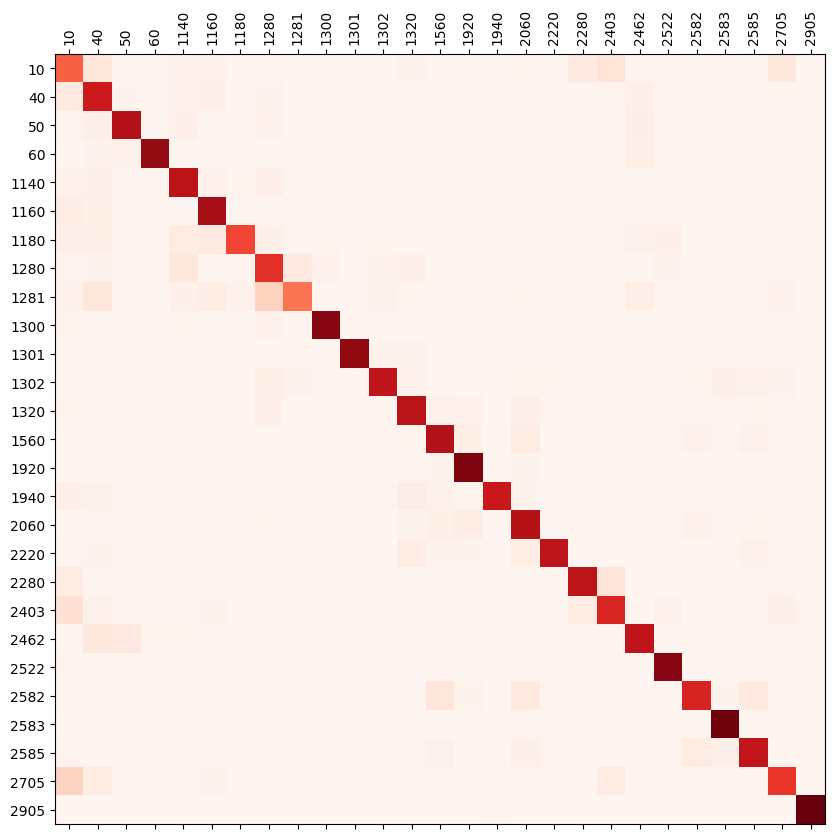

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
#cm_normalized=cm.div(cm.sum(axis=1), axis=0)
cax = ax.matshow(cm_normalized, cmap='Reds')
plt.xticks(range(27),catdict,rotation=90)
plt.yticks(range(27),catdict,rotation=0)
plt.show()

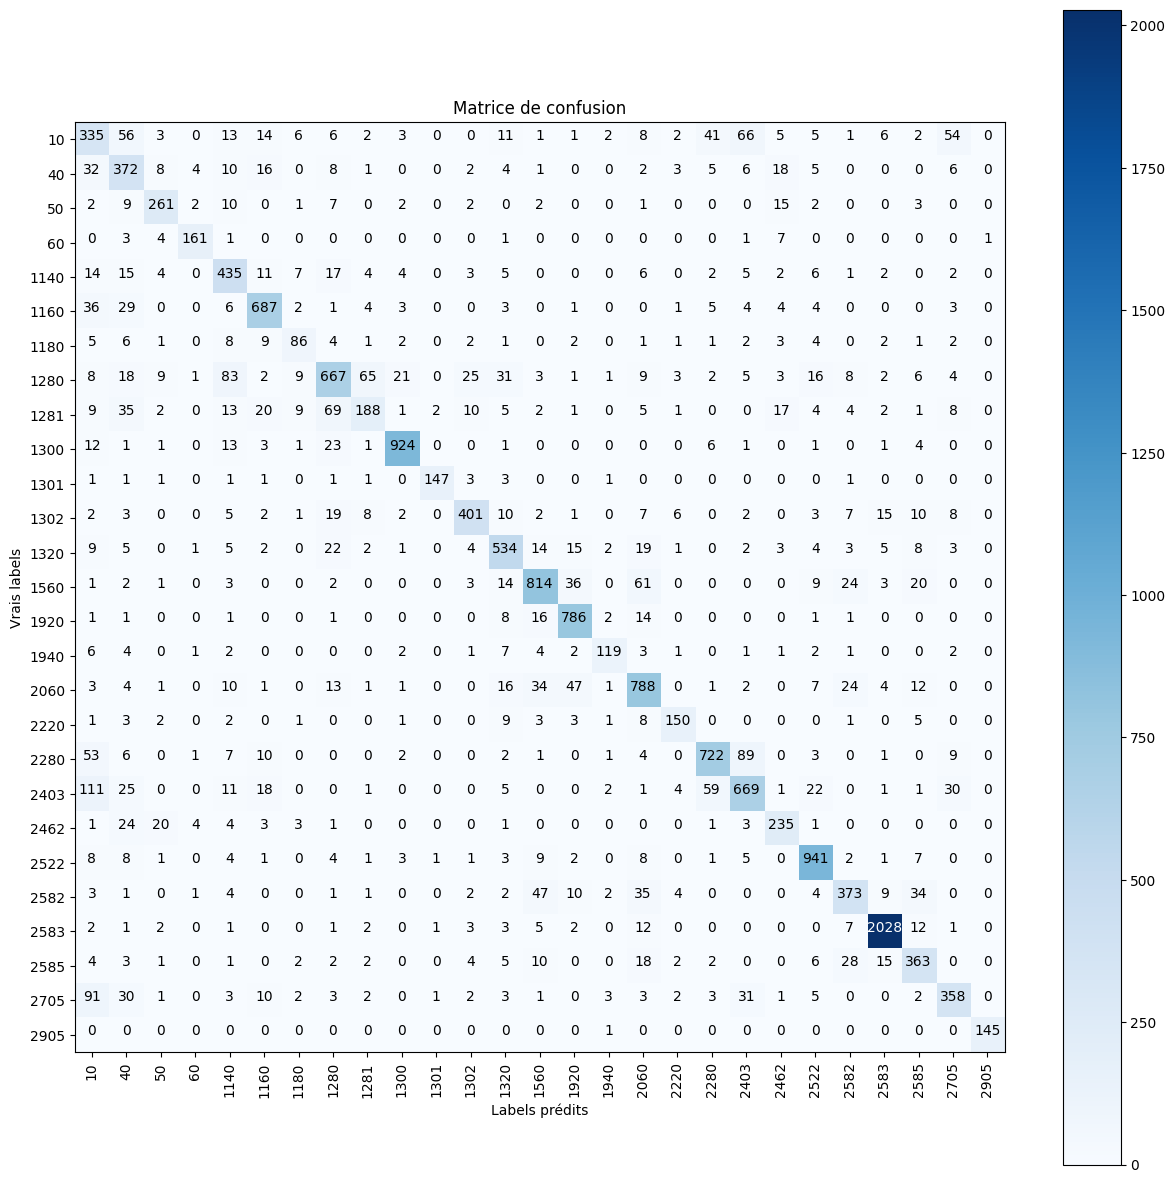

In [33]:
import itertools



# Calcul de la matrice de confusion
cnf_matrix = confusion_matrix(y_test_original, test_pred_original, labels=sorted(list(set(y_test_original))))

# Définition des classes
classes = sorted(list(set(y_test_original)))

# Création et configuration de la figure
plt.figure(figsize=(15, 15))
plt.imshow(cnf_matrix, interpolation='nearest', cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()

# Configuration des ticks
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

# Annotation de chaque cellule de la matrice de confusion
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > (cnf_matrix.max() / 2) else "black")

# Labels pour les axes
plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')

# Affichage de la matrice de confusion
plt.show()

## Etude des catégories 10 ; 2280 ; 2403 ; 2705

In [34]:
df_livres=df_test[df_test['prdtypecode'].isin([10,2280,2403,2705])]
df_livres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3072 entries, 58440 to 46826
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tokenized    3072 non-null   object
 1   prdtypecode  3072 non-null   int64 
 2   predict      3072 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 96.0+ KB


In [35]:
df_livres.head()

,tokenized,prdtypecode,predict
58440,miroir sprint n° campionnissimo valet,2280,2280
1068,dictionnaire etymologique roman derom second v...,2705,2403
48464,compte rebours mois,2403,40
22835,lot sas,2403,2403
37938,lot premiers tomes etoiles hommes enseignement...,2403,2403


### Tableau des 5 classes les plus prédites pour chaque classe réélle

In [36]:

for c in [10,2280,2403,2705]:
    print(c,'   ------   ', catdict[c] )
    print(df_livres[df_livres['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
predict
10      0.520995
2403    0.102644
40      0.087092
2705    0.083981
2280    0.063764
Name: proportion, dtype: float64
2280    ------    magazines
predict
2280    0.792536
2403    0.097695
10      0.058178
1160    0.010977
2705    0.009879
Name: proportion, dtype: float64
2403    ------    livres et bds
predict
2403    0.696150
10      0.115505
2280    0.061394
2705    0.031217
40      0.026015
Name: proportion, dtype: float64
2705    ------    bds et livres
predict
2705    0.642729
10      0.163375
2403    0.055655
40      0.053860
1160    0.017953
Name: proportion, dtype: float64


### Répartition des 20 mots les plus présents sur l'ensemble de ces catégories

In [37]:
import pandas as pd
from collections import Counter

df_livres['tokenized_2'] = df_livres['tokenized'].apply(lambda x: x.split())
# Étape 1 : Identifier les 20 mots les plus fréquents
all_words = sum(df_livres['tokenized_2'].tolist(), [])
global_word_counts = Counter(all_words)
top_20_words = global_word_counts.most_common(20)

# Étape 2 : Calculer le nombre d'occurrences de chaque mot pour chaque classe et globalement
# Initialiser les données pour le DataFrame
data = {"Word": [word for word, count in top_20_words], "Total": [count for word, count in top_20_words]}
class_ids = df_livres['prdtypecode'].unique()

# Calculer les occurrences par classe pour chaque mot
for class_id in class_ids:
    data[class_id] = []
    for word, _ in top_20_words:
        word_count = sum(row.count(word) for row in df_livres[df_livres['prdtypecode'] == class_id]['tokenized_2'])
        data[class_id].append(word_count)

# Étape 3 : Créer le DataFrame
df_word_counts = pd.DataFrame(data)
df_word_counts.set_index("Word", inplace=True)

# Afficher le DataFrame
print(df_word_counts)
df_total_livres=df_word_counts

            Total  2280  2705  2403  10
Word                                   
n°            962   763     4   151  44
lot           426     0     0   426   0
vie           231    33   151    29  18
livres        221     5    13   189  14
monde         179    54   106    14   5
tome          170     6    58    66  40
france        160    73    35    33  19
livre         157     3    83    34  37
histoire      141    24    70    28  19
temps         108     9    74    14  11
paris         102    55    26    15   6
collection    100    10    16    58  16
jean           97    39    21    25  12
journal        96    66     7    16   7
homme          96     6    77     6   7
edition        96     4     9    40  43
bien           95     7    85     2   1
guerre         92    25    37    21   9
faire          90     8    78     3   1
petit          88    29    41    13   5


/tmp/ipykernel_20/1003441623.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_livres['tokenized_2'] = df_livres['tokenized'].apply(lambda x: x.split())


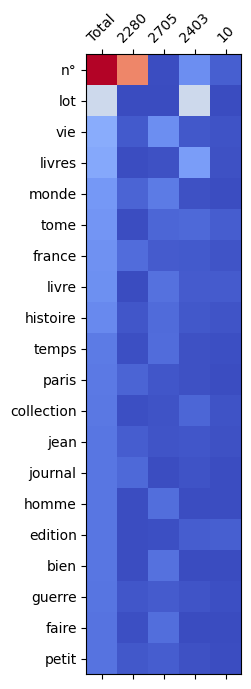

In [38]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_livres.iloc[0:20], cmap = 'coolwarm')
plt.xticks(range(5),(df_total_livres.columns.tolist()),rotation=45)
plt.yticks(range(20),df_total_livres.iloc[0:20].index,rotation=0)
plt.show()



In [39]:
df_total_livres.head(20)

,Total,2280,2705,2403,10
Word,,,,,
n°,962,763,4,151,44
lot,426,0,0,426,0
vie,231,33,151,29,18
livres,221,5,13,189,14
monde,179,54,106,14,5
tome,170,6,58,66,40
france,160,73,35,33,19
livre,157,3,83,34,37
histoire,141,24,70,28,19


## Etude des catégories 1280,1281

In [40]:
df_jouets=df_test[df_test['prdtypecode'].isin([1280,1281])]

### Répartition des 20 mots les plus présents sur l'ensemble de ces catégories

In [41]:
import pandas as pd
from collections import Counter

df_jouets['tokenized_2'] = df_jouets['tokenized'].apply(lambda x: x.split())
# Étape 1 : Identifier les 20 mots les plus fréquents
all_words = sum(df_jouets['tokenized_2'].tolist(), [])
global_word_counts = Counter(all_words)
top_20_words = global_word_counts.most_common(20)

# Étape 2 : Calculer le nombre d'occurrences de chaque mot pour chaque classe et globalement
# Initialiser les données pour le DataFrame
data = {"Word": [word for word, count in top_20_words], "Total": [count for word, count in top_20_words]}
class_ids = df_jouets['prdtypecode'].unique()

# Calculer les occurrences par classe pour chaque mot
for class_id in class_ids:
    data[class_id] = []
    for word, _ in top_20_words:
        word_count = sum(row.count(word) for row in df_jouets[df_jouets['prdtypecode'] == class_id]['tokenized_2'])
        data[class_id].append(word_count)

# Étape 3 : Créer le DataFrame
df_word_counts = pd.DataFrame(data)
df_word_counts.set_index("Word", inplace=True)

# Afficher le DataFrame
print(df_word_counts)
df_total_jouets=df_word_counts

          Total  1280  1281
Word                       
enfants    1350   940   410
jouet       594   445   149
jouets      593   435   158
bebe        546   416   130
taille      529   423   106
haute       432   337    95
jeu         415   184   231
couleur     372   289    83
toy         372   290    82
qualite     371   276    95
cadeau      345   244   101
poupee      336   247    89
non         305   206    99
voiture     299   263    36
bois        286   194    92
materiel    285   227    58
jouer       275   188    87
produit     273   213    60
batterie    264   241    23
ans         255   177    78


/tmp/ipykernel_20/3304478115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jouets['tokenized_2'] = df_jouets['tokenized'].apply(lambda x: x.split())


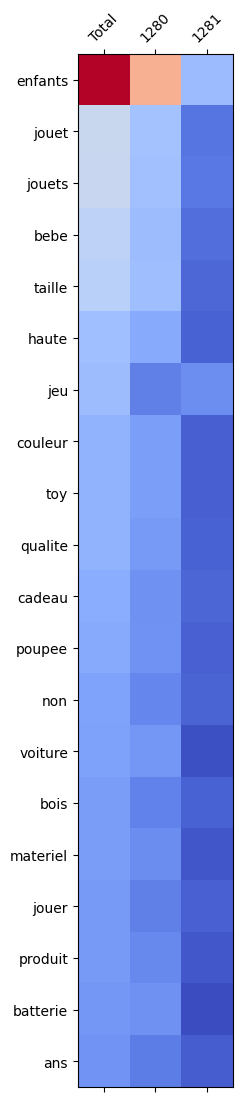

In [42]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_jouets.iloc[0:20], cmap = 'coolwarm')
plt.xticks(range(3),(df_total_jouets.columns.tolist()),rotation=45)
plt.yticks(range(20),df_total_jouets.iloc[0:20].index,rotation=0)
plt.show()